# Discord Profile Picture Generator

### Integrantes:
- Pedro Pablo Arriola Jimenez (20188)
- Marco Pablo Orozco Saravia (20857)
- Santiago Taracena Puga (20017)

## Descripción del Proyecto

Este proyecto tiene como objetivo generar imágenes de perfil de personajes de anime utilizando Redes Antagónicas Generativas (GANs) con PyTorch. Estas imágenes pueden ser utilizadas como fotos de perfil en Discord o en cualquier otra plataforma que permita la personalización de avatares.

### Parte 1 - Importacion de librerias

In [4]:
# Importar las bibliotecas necesarias
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Establecer una semilla aleatoria para la reproducibilidad
manualSeed = 8000
print("Semilla Aleatoria: ", manualSeed)

# Inicializar la semilla aleatoria
random.seed(manualSeed)

# Inicializar la semilla en PyTorch
torch.manual_seed(manualSeed)

# Utilizar algoritmos determinísticos para garantizar resultados reproducibles
torch.use_deterministic_algorithms(True) 

Semilla Aleatoria:  8000


### Parte 2 - Carga del dataset

In [5]:
# Directorio raíz para el conjunto de datos
dataroot = "/home/unclepete/Documents/discord-pfp-gen/kaggle/"

# Número de trabajadores para el cargador de datos
workers = 2

# Tamaño del lote durante el entrenamiento
batch_size = 128

# Tamaño espacial de las imágenes de entrenamiento. Todas las imágenes se redimensionarán a este tamaño.
image_size = 64

# Número de canales en las imágenes de entrenamiento. Para imágenes a color, esto es 3.
nc = 3

# Tamaño del vector latente z (es decir, tamaño de la entrada del generador)
nz = 200

# Tamaño de los mapas de características en el generador
ngf = 64

# Tamaño de los mapas de características en el discriminador
ndf = 64

# Número de épocas de entrenamiento
num_epochs = 100

# Tasa de aprendizaje para los optimizadores
lr = 0.0005

# Hiperparámetro Beta1 para los optimizadores Adam
beta1 = 0.6

# Número de GPUs disponibles. Utilice 0 para el modo CPU.
ngpu = 1

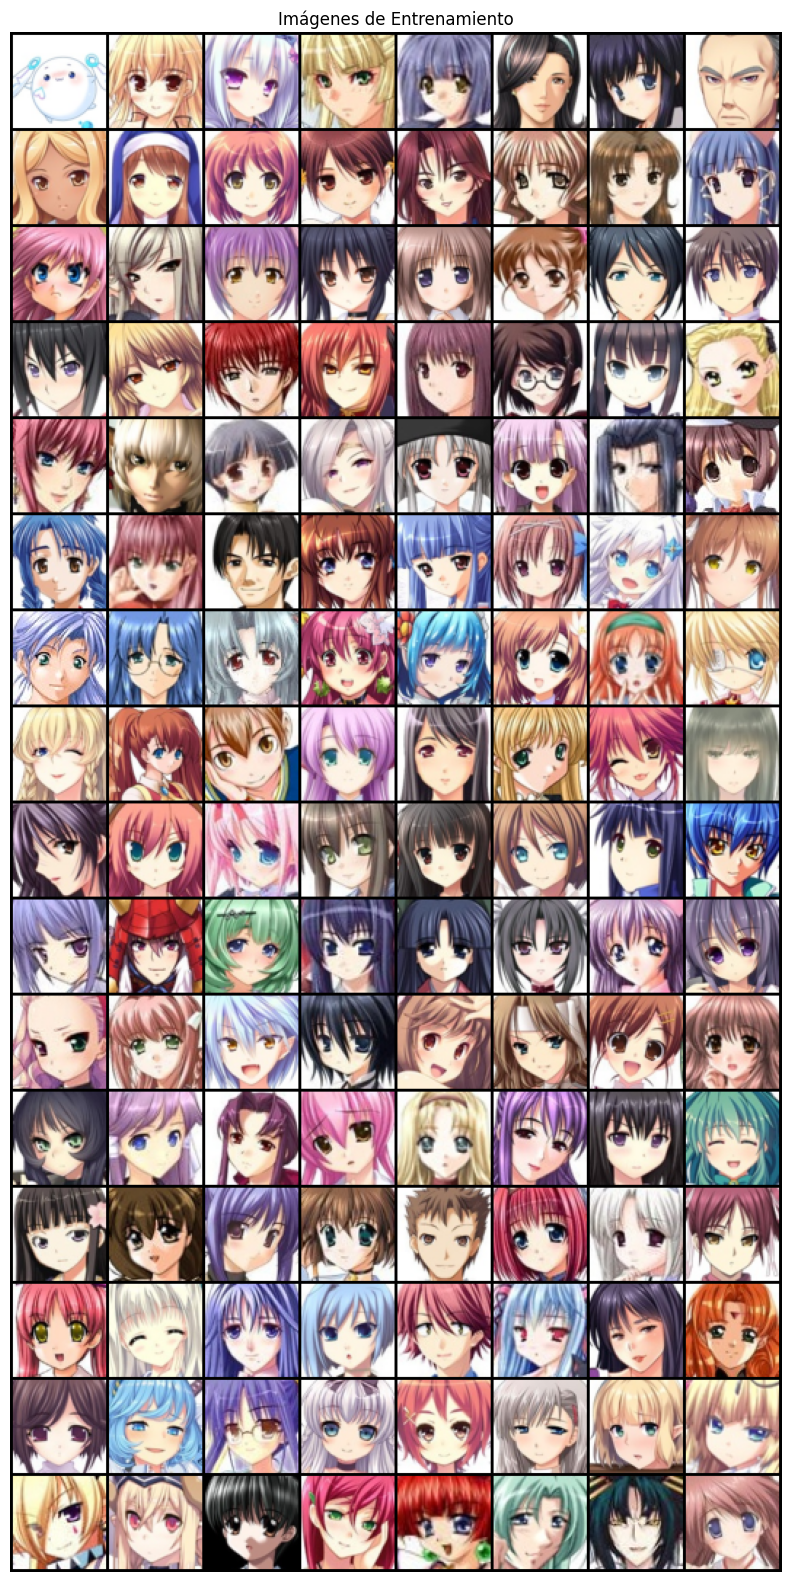

In [9]:
# Crear el conjunto de datos
# Utilizamos la clase ImageFolder para cargar imágenes desde el directorio especificado en 'dataroot'.
# Las transformaciones se aplican a las imágenes: redimensionar, recortar al centro, convertir a tensor y normalizar.
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),          # Redimensionar la imagen
                               transforms.CenterCrop(image_size),      # Recortar al centro
                               transforms.ToTensor(),                  # Convertir la imagen a un tensor
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalizar
                           ]))

# Crear el cargador de datos (dataloader)
# Este manejará el muestreo de lotes de datos para el entrenamiento.
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decidir en qué dispositivo queremos ejecutar el modelo
# Si hay una GPU disponible y ngpu > 0, usaremos CUDA. De lo contrario, usaremos la CPU.
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Mostrar algunas imágenes de entrenamiento
# Aquí tomamos un lote de imágenes del cargador de datos y las visualizamos.
real_batch = next(iter(dataloader))
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.title("Imágenes de Entrenamiento")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:128], padding=2, normalize=True).cpu(), (1, 2, 0)))

### Parte 3 - Implementacion de red GAN

In [10]:
# Inicialización personalizada de pesos, llamada en netG (Generador) y netD (Discriminador)
def weights_init(m):
    # Obtiene el nombre de la clase del módulo
    classname = m.__class__.__name__
    
    # Si el módulo es una capa convolucional
    if classname.find('Conv') != -1:
        # Inicializa los pesos de la capa convolucional con una distribución normal centrada en 0 y una desviación estándar de 0.02
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    # Si el módulo es una capa de normalización por lotes (Batch Normalization)
    elif classname.find('BatchNorm') != -1:
        # Inicializa los pesos de la capa de normalización por lotes con una distribución normal centrada en 1 y una desviación estándar de 0.02
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        
        # Inicializa el sesgo (bias) de la capa de normalización por lotes a 0
        nn.init.constant_(m.bias.data, 0)

In [11]:
# Código del Generador

# Definir la clase del Generador, que hereda de nn.Module (la clase base para todos los módulos de red neuronal en PyTorch)
class Generator(nn.Module):
    # Constructor de la clase
    def __init__(self, ngpu):
        # Llamar al constructor de la clase padre (nn.Module)
        super(Generator, self).__init__()
        
        # Guardar el número de GPUs disponibles
        self.ngpu = ngpu
        
        # Definir la arquitectura del generador como una secuencia de capas
        self.main = nn.Sequential(
            # La entrada es el vector latente Z, que se transforma mediante una convolución transpuesta
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # Tamaño del estado: (ngf*8) x 4 x 4
            
            # Añadir más capas para aumentar la resolución y complejidad de la imagen
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Tamaño del estado: (ngf*4) x 8 x 8
            
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Tamaño del estado: (ngf*2) x 16 x 16
            
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Tamaño del estado: (ngf) x 32 x 32
            
            # La última capa produce una imagen a color (nc canales) con resolución 64x64
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # Tamaño del estado: (nc) x 64 x 64
        )

    # Definir la operación de avance (forward) para el generador
    def forward(self, input):
        return self.main(input)

In [12]:
# Crear el generador
# Inicializamos una instancia de la clase Generator y la movemos al dispositivo donde se llevará a cabo el cálculo (CPU o GPU).
netG = Generator(ngpu).to(device)

# Manejar múltiples GPUs si se desea
# Si estamos en un entorno con múltiples GPUs y ngpu > 1, utilizamos nn.DataParallel para dividir el trabajo entre ellas.
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Aplicar la función weights_init para inicializar aleatoriamente todos los pesos
# con una media de 0 y una desviación estándar de 0.2.
netG.apply(weights_init)

# Imprimir el modelo
# Esto es útil para verificar la arquitectura y asegurarnos de que todo está configurado como esperamos.
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(200, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [13]:
# Definir la clase del Discriminador, que también hereda de nn.Module
class Discriminator(nn.Module):
    # Constructor de la clase
    def __init__(self, ngpu):
        # Llamar al constructor de la clase padre (nn.Module)
        super(Discriminator, self).__init__()
        
        # Guardar el número de GPUs disponibles
        self.ngpu = ngpu
        
        # Definir la arquitectura del discriminador como una secuencia de capas
        self.main = nn.Sequential(
            # La entrada es una imagen con canales nc y tamaño 64x64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño del estado: (ndf) x 32 x 32
            
            # Añadir más capas para reducir progresivamente la resolución de la imagen
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño del estado: (ndf*2) x 16 x 16
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño del estado: (ndf*4) x 8 x 8
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño del estado: (ndf*8) x 4 x 4
            
            # La última capa reduce todo a una única salida: la probabilidad de que la imagen sea real
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    # Definir la operación de avance (forward) para el discriminador
    def forward(self, input):
        return self.main(input)

In [ ]:
# Crear el Discriminador
# Inicializamos una instancia de la clase Discriminator y la movemos al dispositivo donde se llevará a cabo el cálculo (CPU o GPU).
netD = Discriminator(ngpu).to(device)

# Manejar múltiples GPUs si se desea
# Si estamos en un entorno con múltiples GPUs y ngpu > 1, utilizamos nn.DataParallel para dividir el trabajo entre ellas.
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Aplicar la función weights_init para inicializar aleatoriamente todos los pesos
# con una media de 0 y una desviación estándar de 0.2.
netD.apply(weights_init)

# Imprimir el modelo
# Esto es útil para verificar la arquitectura y asegurarnos de que todo está configurado como esperamos.
print(netD)